# Parte 1: Ciclo de vida de un modelo - Preparación y EDA
*   **Autor:** Carolina Torres Zapata
*   **Fecha:** 2025-11-24
*   **Propósito:** Cargar el dataset Telco Customer Churn, realizar un EDA mínimo y preparar los datos para mod]elado.
*   **Resumen del Flujo:**
     1. Descargar datos crudos desde fuente externa y persistirlos en la capa **Bronze** (Raw).
     2. Realizar perfilamiento básico (EDA) para identificar nulos, tipos de datos incorrectos y desbalance de clases.
     3. Limpiar y estructurar los datos para la capa **Silver**, dejándolos listos para el pipeline de entrenamiento.

**Arquitectura de Datos (Medallion)**
Se utiliza una estructura de capas lógica para garantizar trazabilidad:
*   `dev.bronze`: Datos crudos inmutables.
*   `devo.silver`: Datos limpios y estructurados (Input para modelos).
   

## Creación Catálogo y Tablas
Creación de los esquemas (bases de datos) para organizar las tablas
Arquitectura y convenciones<br>
• Crear catalogo llamado dev<br>
• Crear dos esquemas llamados bronce y silver<br>
• **Capa Bronce** (Raw/Ingesta): Datos exactamente como llegan de la fuente, sin cambiarles nada.<br>
• **Capa Silver** (Clean/Refined): Datos limpios y estructurados.<br>

In [0]:
%sql
-- Celda 1: Creación de la estructura
CREATE CATALOG IF NOT EXISTS dev;
USE CATALOG dev;
CREATE SCHEMA IF NOT EXISTS bronce;
CREATE SCHEMA IF NOT EXISTS silver;

## 1. Importar Librerías

In [0]:
#!pip install ydata-profiling

In [0]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import re

from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

## 2. Carga y Exploración Inicial de los Datos

### 2.1. Ingesta y Capa Bronce
Descargamos el dataset "Telco Customer Churn" directamente de la fuente raw para garantizar reproducibilidad. Los datos se guardan inmediatamente en la capa **Bronze** para tener un respaldo histórico inmutable.

In [0]:

# URL del dataset (Fuente: IBM/Kaggle repository)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    # 1. Lectura en memoria (Pandas)
    print(f"⬇️ Descargando datos desde: {url}")
    df = pd.read_csv(url)
    
    # 2. Persistencia en BRONCE (Spark Delta Table)
    # Convertimos a Spark para aprovechar el almacenamiento optimizado de Databricks
    df_raw_spark = spark.createDataFrame(df)
    
    df_raw_spark.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("dev.bronce.telco_customer_churn")
    
    print(f"   Registros: {df.shape[0]} | Columnas: {df.shape[1]}")

except Exception as e:
    print(f"❌ Error crítico en la ingesta: {e}")

⬇️ Descargando datos desde: https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
   Registros: 7043 | Columnas: 21


### 2.2. Análisis Exploratorio de Datos (EDA) Mínimo
Realizamos validaciones clave para determinar la estrategia de limpieza.
*   Tipos de datos.
*   Valores nulos o inconsistentes.
*   Distribución de la variable objetivo (`Churn`).

In [0]:
def info_completa(df, nombre_df):
    print(f"\n📊 --- INFORME: {nombre_df} ---")
    print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print("\nTipos de datos:")
    print(df.dtypes)
    
    print("\nValores nulos por columna:")
    print(df.isnull().sum())

    print("\nValores únicos por columna:")
    print(df.nunique())

    print("\n=== DUPLICADOS ===")
    print(f"Total duplicados: {df.duplicated().sum()}")

    print("\nPorcentaje de valores faltantes por columna:")
    print((df.isnull().mean() * 100).round(2))

    print("\nPrimeras 5 filas:")
    display(df.head(5))


info_completa(df, "Telco Customer Churn")


📊 --- INFORME: Telco Customer Churn ---
Dimensiones: 7043 filas x 21 columnas

Tipos de datos:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Valores nulos por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSuppor

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes


#### Análisis Variable Objetivo

In [0]:
# Distribución de la variable objetivo
print("\n📌 Distribución de Churn:")
print(df["Churn"].value_counts())
print("\nPorcentaje:")
print(df["Churn"].value_counts(normalize=True) * 100)


📌 Distribución de Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Porcentaje:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [0]:
def plot_categoricas_vs_target(df, target="Churn"):
    """
    Grafica variables categóricas vs la variable objetivo.
    
    Parámetros:
    df (DataFrame): dataframe original
    target (str): nombre de la variable objetivo
    """
    
    # columnas categorías
    categoricas = df.select_dtypes(include=["object"]).columns.tolist()
    
    # excluir ID y target (si es object)
    for col in ["customerID", target]:
        if col in categoricas:
            categoricas.remove(col)
    
    print(f"Variables categóricas detectadas: {categoricas}")
    
    for col in categoricas:
        fig = px.histogram(
            df,
            x=col,
            color=target,
            barmode="group",
            title=f"{col} vs {target}",
            template="plotly_white"
        )
        fig.update_layout(xaxis_title=col, yaxis_title="Count")
        fig.show()


plot_categoricas_vs_target(df)


Variables categóricas detectadas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']



=== Variables numéricas vs CHURN ===



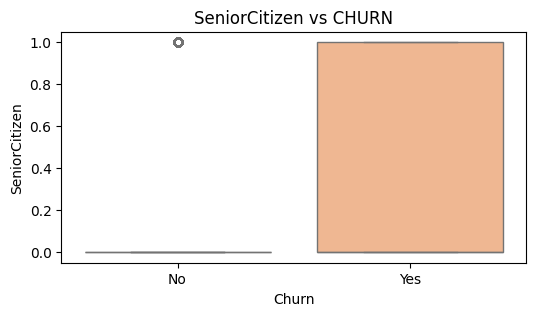

       mean  median   std
Churn                    
No     0.13     0.0  0.33
Yes    0.25     0.0  0.44 



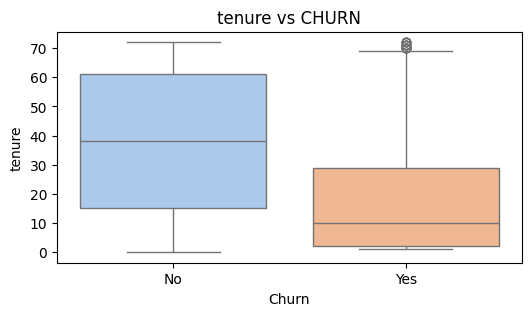

        mean  median    std
Churn                      
No     37.57    38.0  24.11
Yes    17.98    10.0  19.53 



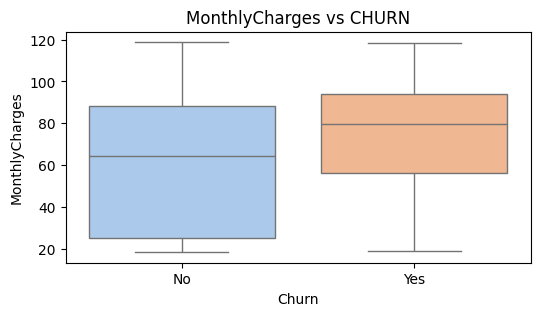

        mean  median    std
Churn                      
No     61.27   64.43  31.09
Yes    74.44   79.65  24.67 



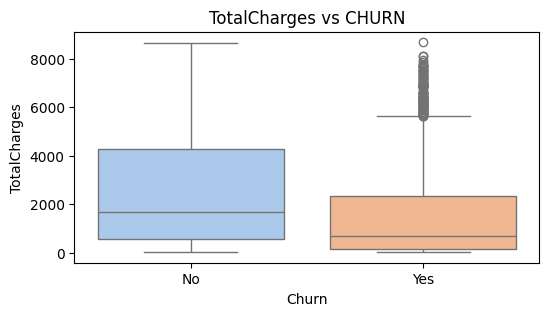

          mean   median      std
Churn                           
No     2555.34  1683.60  2329.46
Yes    1531.80   703.55  1890.82 



In [0]:
# Convertir TotalCharges a numérico
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

num_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

for target in ['Churn']:
    print(f"\n=== Variables numéricas vs {target.upper()} ===\n")
    for col in num_features:
        if col in df.columns:
            plt.figure(figsize=(6,3))
            sns.boxplot(x=target, y=col, data=df, palette='pastel')
            plt.title(f"{col} vs {target.upper()}")
            plt.show()
            
            stats = df.groupby(target)[col].agg(['mean','median','std']).round(2)
            print(stats, "\n")

## 3. Transformación y Capa Silver
Aplicamos reglas de negocio y limpieza técnica:
1.  **Corrección de Tipos:** `TotalCharges` se convierte a numérico.
2.  **Imputación:** Los valores vacíos se rellenan con la media.

**Estrategia de Transformación:**

1.  **Gestión de Identificadores:** Se aísla el `customerID` antes de las transformaciones para preservarlo. Esto es vital para la **trazabilidad del negocio** en la etapa de inferencia (saber qué cliente específico tiene riesgo de fuga).
2.  **Variables Numéricas (`StandardScaler`):** Se estandarizan columnas como `tenure`, `MonthlyCharges` y `TotalCharges` para que tengan media 0 y desviación estándar 1, optimizando la convergencia de algoritmos lineales.
3.  **Variables Categóricas (`OneHotEncoder`):** Se convierten las variables nominales (ej. `InternetService`, `PaymentMethod`) en variables dummy numéricas.
    *   *Configuración:* Se utiliza `drop='first'` para evitar la multicolinealidad (trampa de las variables ficticias).
4.  **Reconstrucción del Dataset:** Finalmente, se concatenan las características transformadas con el `Target` y el `customerID`, reordenando las columnas para dejar el identificador al inicio por facilidad de lectura.

In [0]:
# 5.1 Hacer copia de trabajo
df_clean = df.copy()

# 5.2 TotalCharges -> numérico y imputación
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")
df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(df_clean["TotalCharges"].mean())

# 5.3 Tratar SeniorCitizen como categórica (0/1 => categoría)
df_clean["SeniorCitizen"] = df_clean["SeniorCitizen"].astype("object")

# Guardamos el ID en una variable separada para pegarlo al final
ids = df_clean["customerID"].values 

# 5.4 Codificar target (No en el transformer)
df_clean["Churn"] = df_clean["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# 5.5 Separar X e y (y fuera del pipeline)
y = df_clean["Churn"]
X = df_clean.drop(columns=["Churn", "customerID"])  # customerID lo excluimos del modelado

# 5.6 Identificar columnas categóricas y numéricas
categoricas = X.select_dtypes(include=["object"]).columns.tolist()
numericas = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\n📌 Categóricas detectadas:", categoricas)
print("📌 Numéricas detectadas:", numericas)

# 5.7 Definir ColumnTransformer con OHE (drop='first') y StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categoricas),
        ("num", StandardScaler(), numericas)
    ],
    remainder="drop"  # solo dejamos las columnas procesadas
)

# 5.8 Fit + transform (sobre X)
X_encoded_np = preprocessor.fit_transform(X)

# 5.9 Obtener nombres de columnas RESULTANTES de forma robusta
# Este método devuelve los nombres en el mismo orden que las columnas del output
feature_names = preprocessor.get_feature_names_out()

# 5.10 Construir DataFrame codificado de forma segura
X_encoded = pd.DataFrame(X_encoded_np, columns=feature_names)

# 5.11 Volver a añadir el target al final
df_encoded = X_encoded.copy()
df_encoded["Churn"] = y.values
df_encoded["customerID"] = ids 

# Obtener nombre de la última columna
ultima_columna = df_encoded.columns[-1]

# Crear nueva lista de columnas con la última al principio
columnas_reordenadas = [ultima_columna] + df_encoded.columns[:-1].tolist()

# Reindexar el DataFrame
df_encoded = df_encoded.reindex(columns=columnas_reordenadas)

print("\n✔ Preprocesamiento completado sin desalineación")
print("Shape df_encoded:", df_encoded.shape)
display(df_encoded.head())


📌 Categóricas detectadas: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
📌 Numéricas detectadas: ['tenure', 'MonthlyCharges', 'TotalCharges']

✔ Preprocesamiento completado sin desalineación
Shape df_encoded: (7043, 32)


customerID,cat__gender_Male,cat__SeniorCitizen_1,cat__Partner_Yes,cat__Dependents_Yes,cat__PhoneService_Yes,cat__MultipleLines_No phone service,cat__MultipleLines_Yes,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,num__tenure,num__MonthlyCharges,num__TotalCharges,Churn
7590-VHVEG,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2774445836787656,-1.1603229160349193,-0.9949713816319787,0
5575-GNVDE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.06632741908223598,-0.2596289419448806,-0.1738756538019684,0
3668-QPYBK,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.2367242199587352,-0.3626603559551803,-0.9603993947048204,1
7795-CFOCW,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5142514200025698,-0.7465354629935549,-0.19540035830642513,0
9237-HQITU,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2367242199587352,0.19736523310080326,-0.9411927353008436,1


### Normalización de Nombres (Compatibilidad Delta Lake)
Se aplica una función de limpieza (`sanitización`) a los nombres de las columnas para eliminar espacios, paréntesis y caracteres especiales. Este paso es **obligatorio** para evitar errores de sintaxis al guardar el DataFrame como tabla en Spark/Delta.

In [0]:
def clean_column_name(col):
    col = col.strip()

    # Eliminar prefijos del ColumnTransformer
    col = col.replace("cat__", "")
    col = col.replace("num__", "")

    # Reemplazar espacios por _ 
    col = col.replace(" ", "_")
    col = col.replace("_Yes", "")
    col = col.replace("_1", "")

    # Eliminar paréntesis
    col = col.replace("(", "").replace(")", "")

    # Reemplazar guiones por _
    col = col.replace("-", "_")

    # Eliminar caracteres especiales NO permitidos
    col = re.sub(r"[^0-9a-zA-Z_]+", "", col)

    # Reducir múltiples ___ -> _
    col = re.sub("_+", "_", col)

    return col

# Aplicar limpieza
df_encoded.columns = [clean_column_name(c) for c in df_encoded.columns]

print("\n✔ Nombres de columnas normalizados para Spark/Delta:")
print(df_encoded.columns.tolist()[:40])  # mostrar las primeras 40 columnas
display(df_encoded.head())


✔ Nombres de columnas normalizados para Spark/Delta:
['customerID', 'gender_Male', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines_No_phone_service', 'MultipleLines', 'InternetService_Fiber_optic', 'InternetService_No', 'OnlineSecurity_No_internet_service', 'OnlineSecurity', 'OnlineBackup_No_internet_service', 'OnlineBackup', 'DeviceProtection_No_internet_service', 'DeviceProtection', 'TechSupport_No_internet_service', 'TechSupport', 'StreamingTV_No_internet_service', 'StreamingTV', 'StreamingMovies_No_internet_service', 'StreamingMovies', 'Contract_One_year', 'Contract_Two_year', 'PaperlessBilling', 'PaymentMethod_Credit_card_automatic', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


customerID,gender_Male,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_No_phone_service,MultipleLines,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity,OnlineBackup_No_internet_service,OnlineBackup,DeviceProtection_No_internet_service,DeviceProtection,TechSupport_No_internet_service,TechSupport,StreamingTV_No_internet_service,StreamingTV,StreamingMovies_No_internet_service,StreamingMovies,Contract_One_year,Contract_Two_year,PaperlessBilling,PaymentMethod_Credit_card_automatic,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,tenure,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2774445836787656,-1.1603229160349193,-0.9949713816319787,0
5575-GNVDE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.06632741908223598,-0.2596289419448806,-0.1738756538019684,0
3668-QPYBK,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.2367242199587352,-0.3626603559551803,-0.9603993947048204,1
7795-CFOCW,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5142514200025698,-0.7465354629935549,-0.19540035830642513,0
9237-HQITU,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2367242199587352,0.19736523310080326,-0.9411927353008436,1


## 4. Guadar Datos Transformados
Convertimos el DataFrame procesado a formato Spark y lo almacenamos en la tabla Delta `dev.silver.churn_data`. Esto asegura que los datos limpios y transformados estén disponibles y centralizados para la fase de entrenamiento.

In [0]:
spark = SparkSession.builder.getOrCreate()

print("\nGuardando tabla limpias en dev.silver.churn_data ...")
spark_df = spark.createDataFrame(df_encoded)  # pandas -> spark

# Si quieres validar antes:
print("Primeras filas Spark:")
display(spark_df.limit(5).toPandas())

# Guardar como tabla Delta en esquema 'dev.silver'
spark_df.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("dev.silver.churn_data")
print("✔ Tabla dev.silver.churn_data creada/reemplazada correctamente.")


Guardando tabla limpias en dev.silver.churn_data ...
Primeras filas Spark:


customerID,gender_Male,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_No_phone_service,MultipleLines,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity,OnlineBackup_No_internet_service,OnlineBackup,DeviceProtection_No_internet_service,DeviceProtection,TechSupport_No_internet_service,TechSupport,StreamingTV_No_internet_service,StreamingTV,StreamingMovies_No_internet_service,StreamingMovies,Contract_One_year,Contract_Two_year,PaperlessBilling,PaymentMethod_Credit_card_automatic,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,tenure,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2774445836787656,-1.1603229160349193,-0.9949713816319787,0
5575-GNVDE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.06632741908223598,-0.2596289419448806,-0.1738756538019684,0
3668-QPYBK,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.2367242199587352,-0.3626603559551803,-0.9603993947048204,1
7795-CFOCW,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5142514200025698,-0.7465354629935549,-0.19540035830642513,0
9237-HQITU,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.2367242199587352,0.19736523310080326,-0.9411927353008436,1


✔ Tabla dev.silver.churn_data creada/reemplazada correctamente.


##5. Guadar la data limpia (Negocio)
Guardamos una copia de los datos limpios (sin nulos ni errores) pero **sin transformar** en la tabla `dev.silver.clean_data`. Esta versión conserva los valores originales (texto legible) para garantizar el contexto de negocio, trazabilidad y facilitar el análisis posterior o el enriquecimiento de reportes.

In [0]:
print("\nGuardando tabla limpias en dev.silver.clean_data ...")
spark_df_clean = spark.createDataFrame(df_clean)  # pandas -> spark

# Si quieres validar antes:
print("Primeras filas Spark:")
display(spark_df_clean.limit(5).toPandas())

# Guardar como tabla Delta en esquema 'dev.silver'
spark_df_clean.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("dev.silver.clean_data")
print("✔ Tabla dev.silver.clean_data creada/reemplazada correctamente.")


Guardando tabla limpias en dev.silver.clean_data ...
Primeras filas Spark:


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,0
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,1


✔ Tabla dev.silver.clean_data creada/reemplazada correctamente.
